In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics.pairwise import euclidean_distances
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)

In [2]:
# Read the data

data = pd.read_csv('Country-data.csv')

In [3]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Since each row represents a country lest use country name as index
data.set_index('country',inplace=True)

In [5]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Data Exploration

In [6]:
print('No of countries:',data.shape[0])

No of countries: 167


In [7]:
# 5 point summary
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


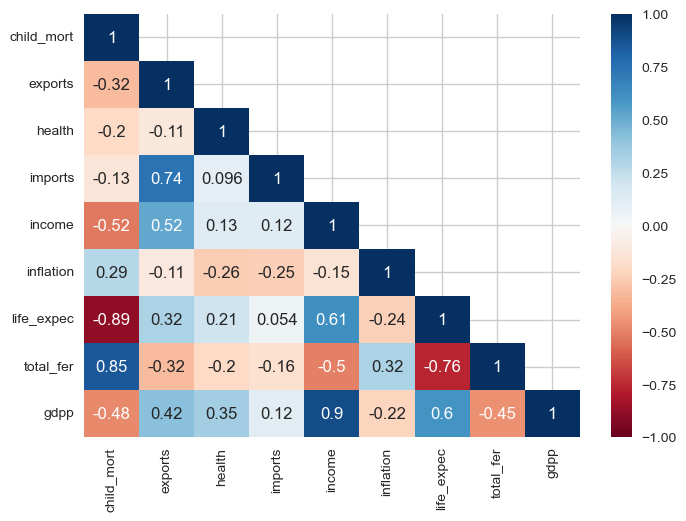

In [8]:
# Lets look at the correlation plot
sns.heatmap(data.corr(),annot=True,vmin=-1,cmap='RdBu',mask=np.triu(data.corr(),k=1))
plt.show()

In [9]:
# Univariate Analysis

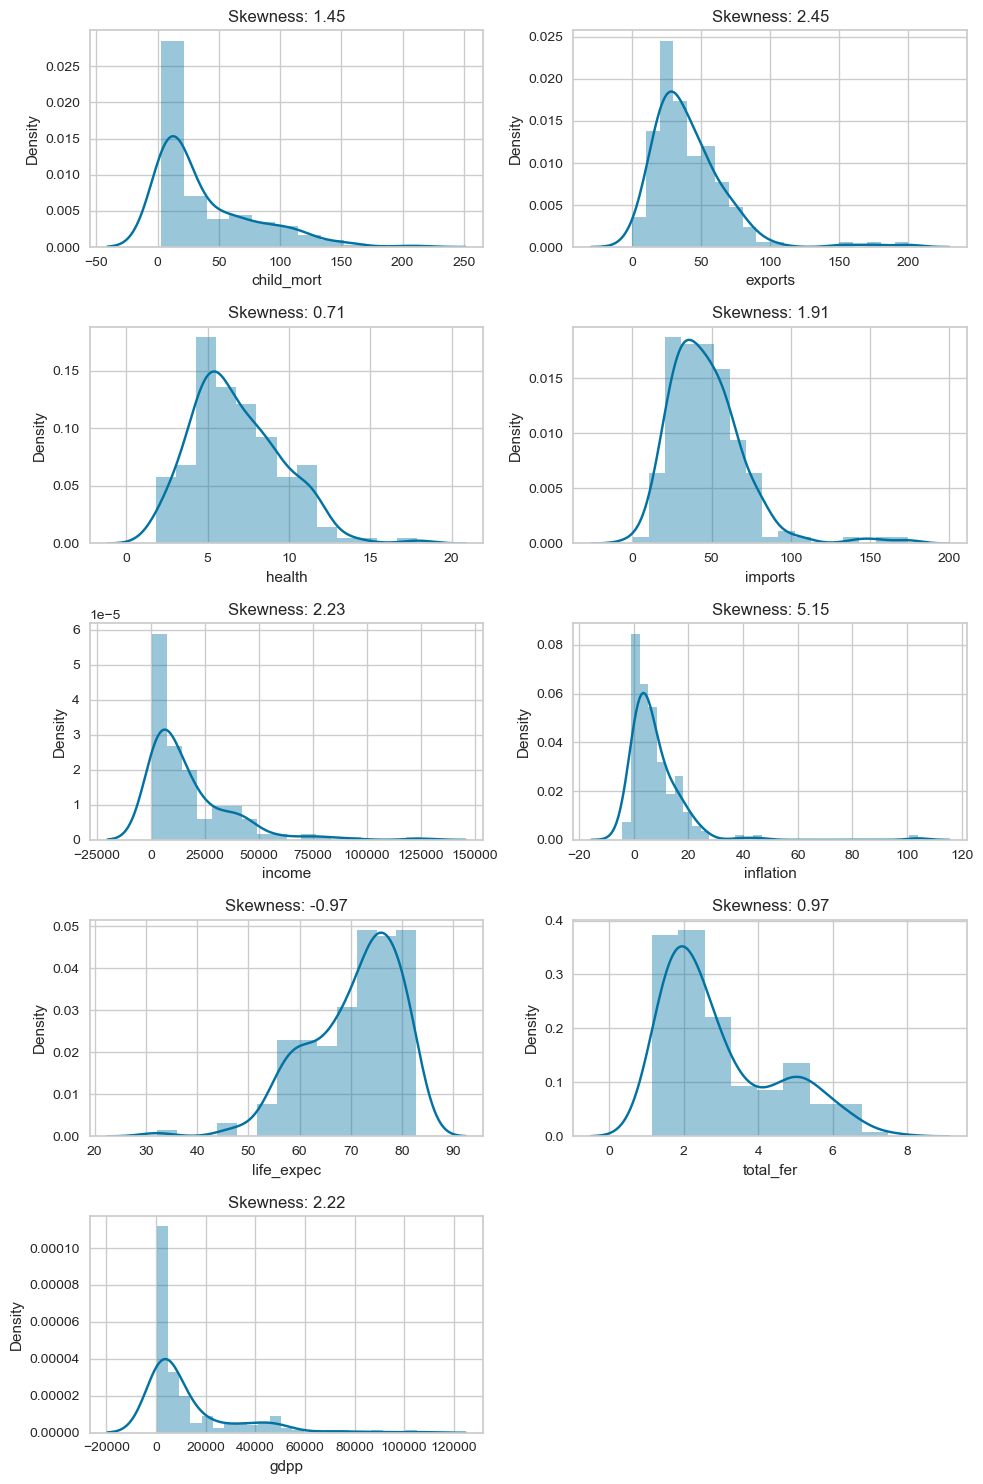

In [10]:
t=1
plt.figure(figsize=(10,15))
for i in data.columns:
    plt.subplot(5,2,t)
    sns.distplot(data[i])
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

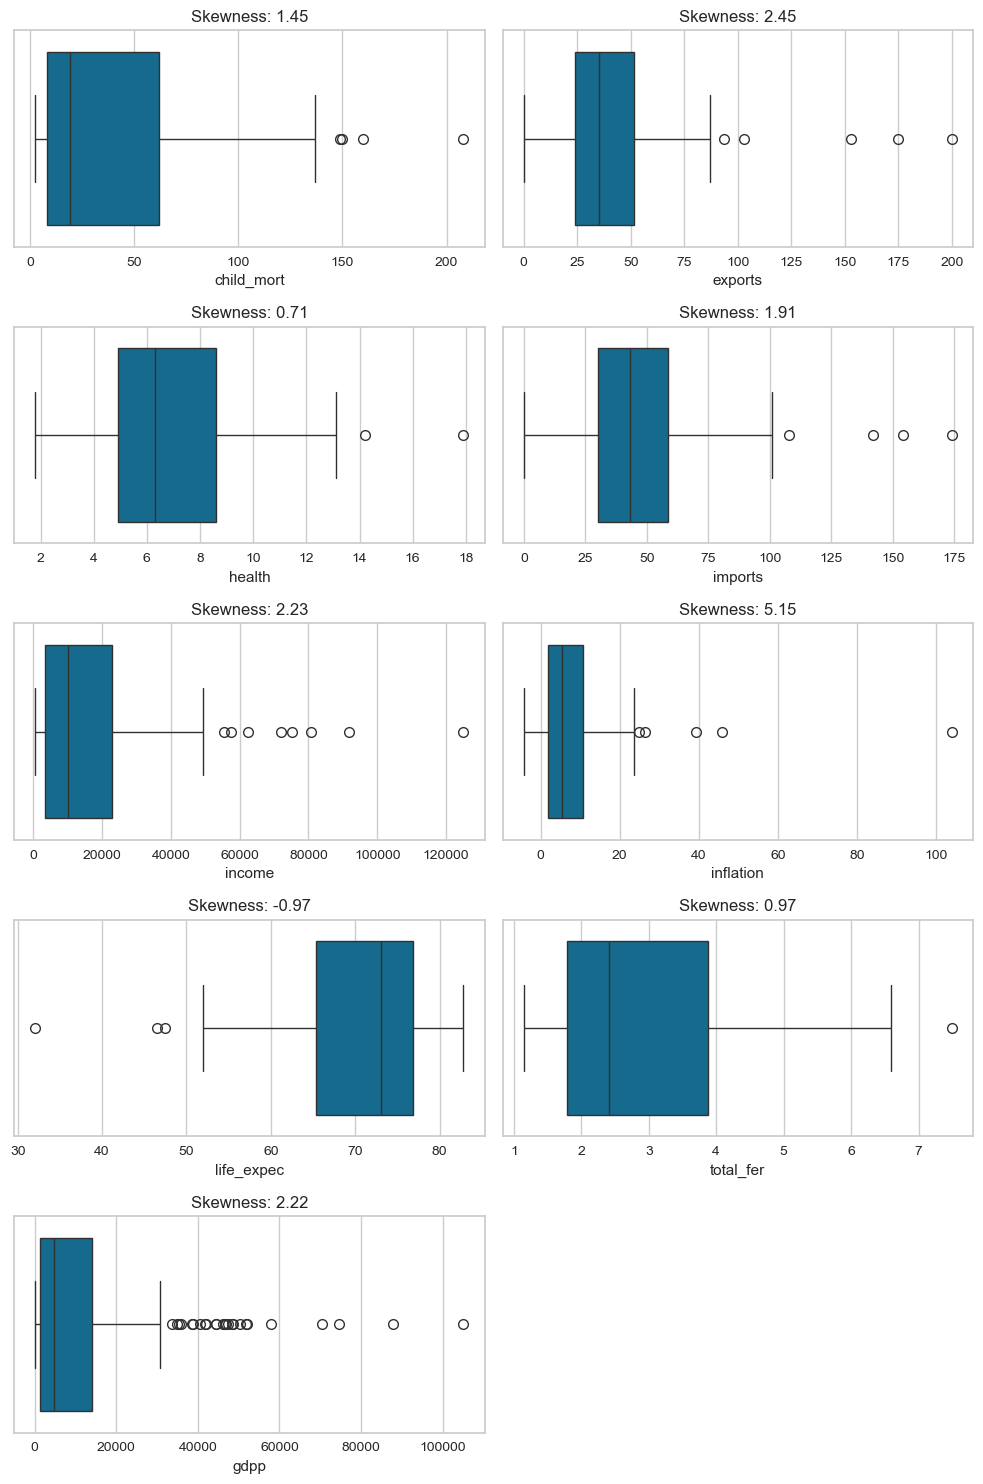

In [11]:
t=1
plt.figure(figsize=(10,15))
for i in data.columns:
    plt.subplot(5,2,t)
    sns.boxplot(data=data,x=i)
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

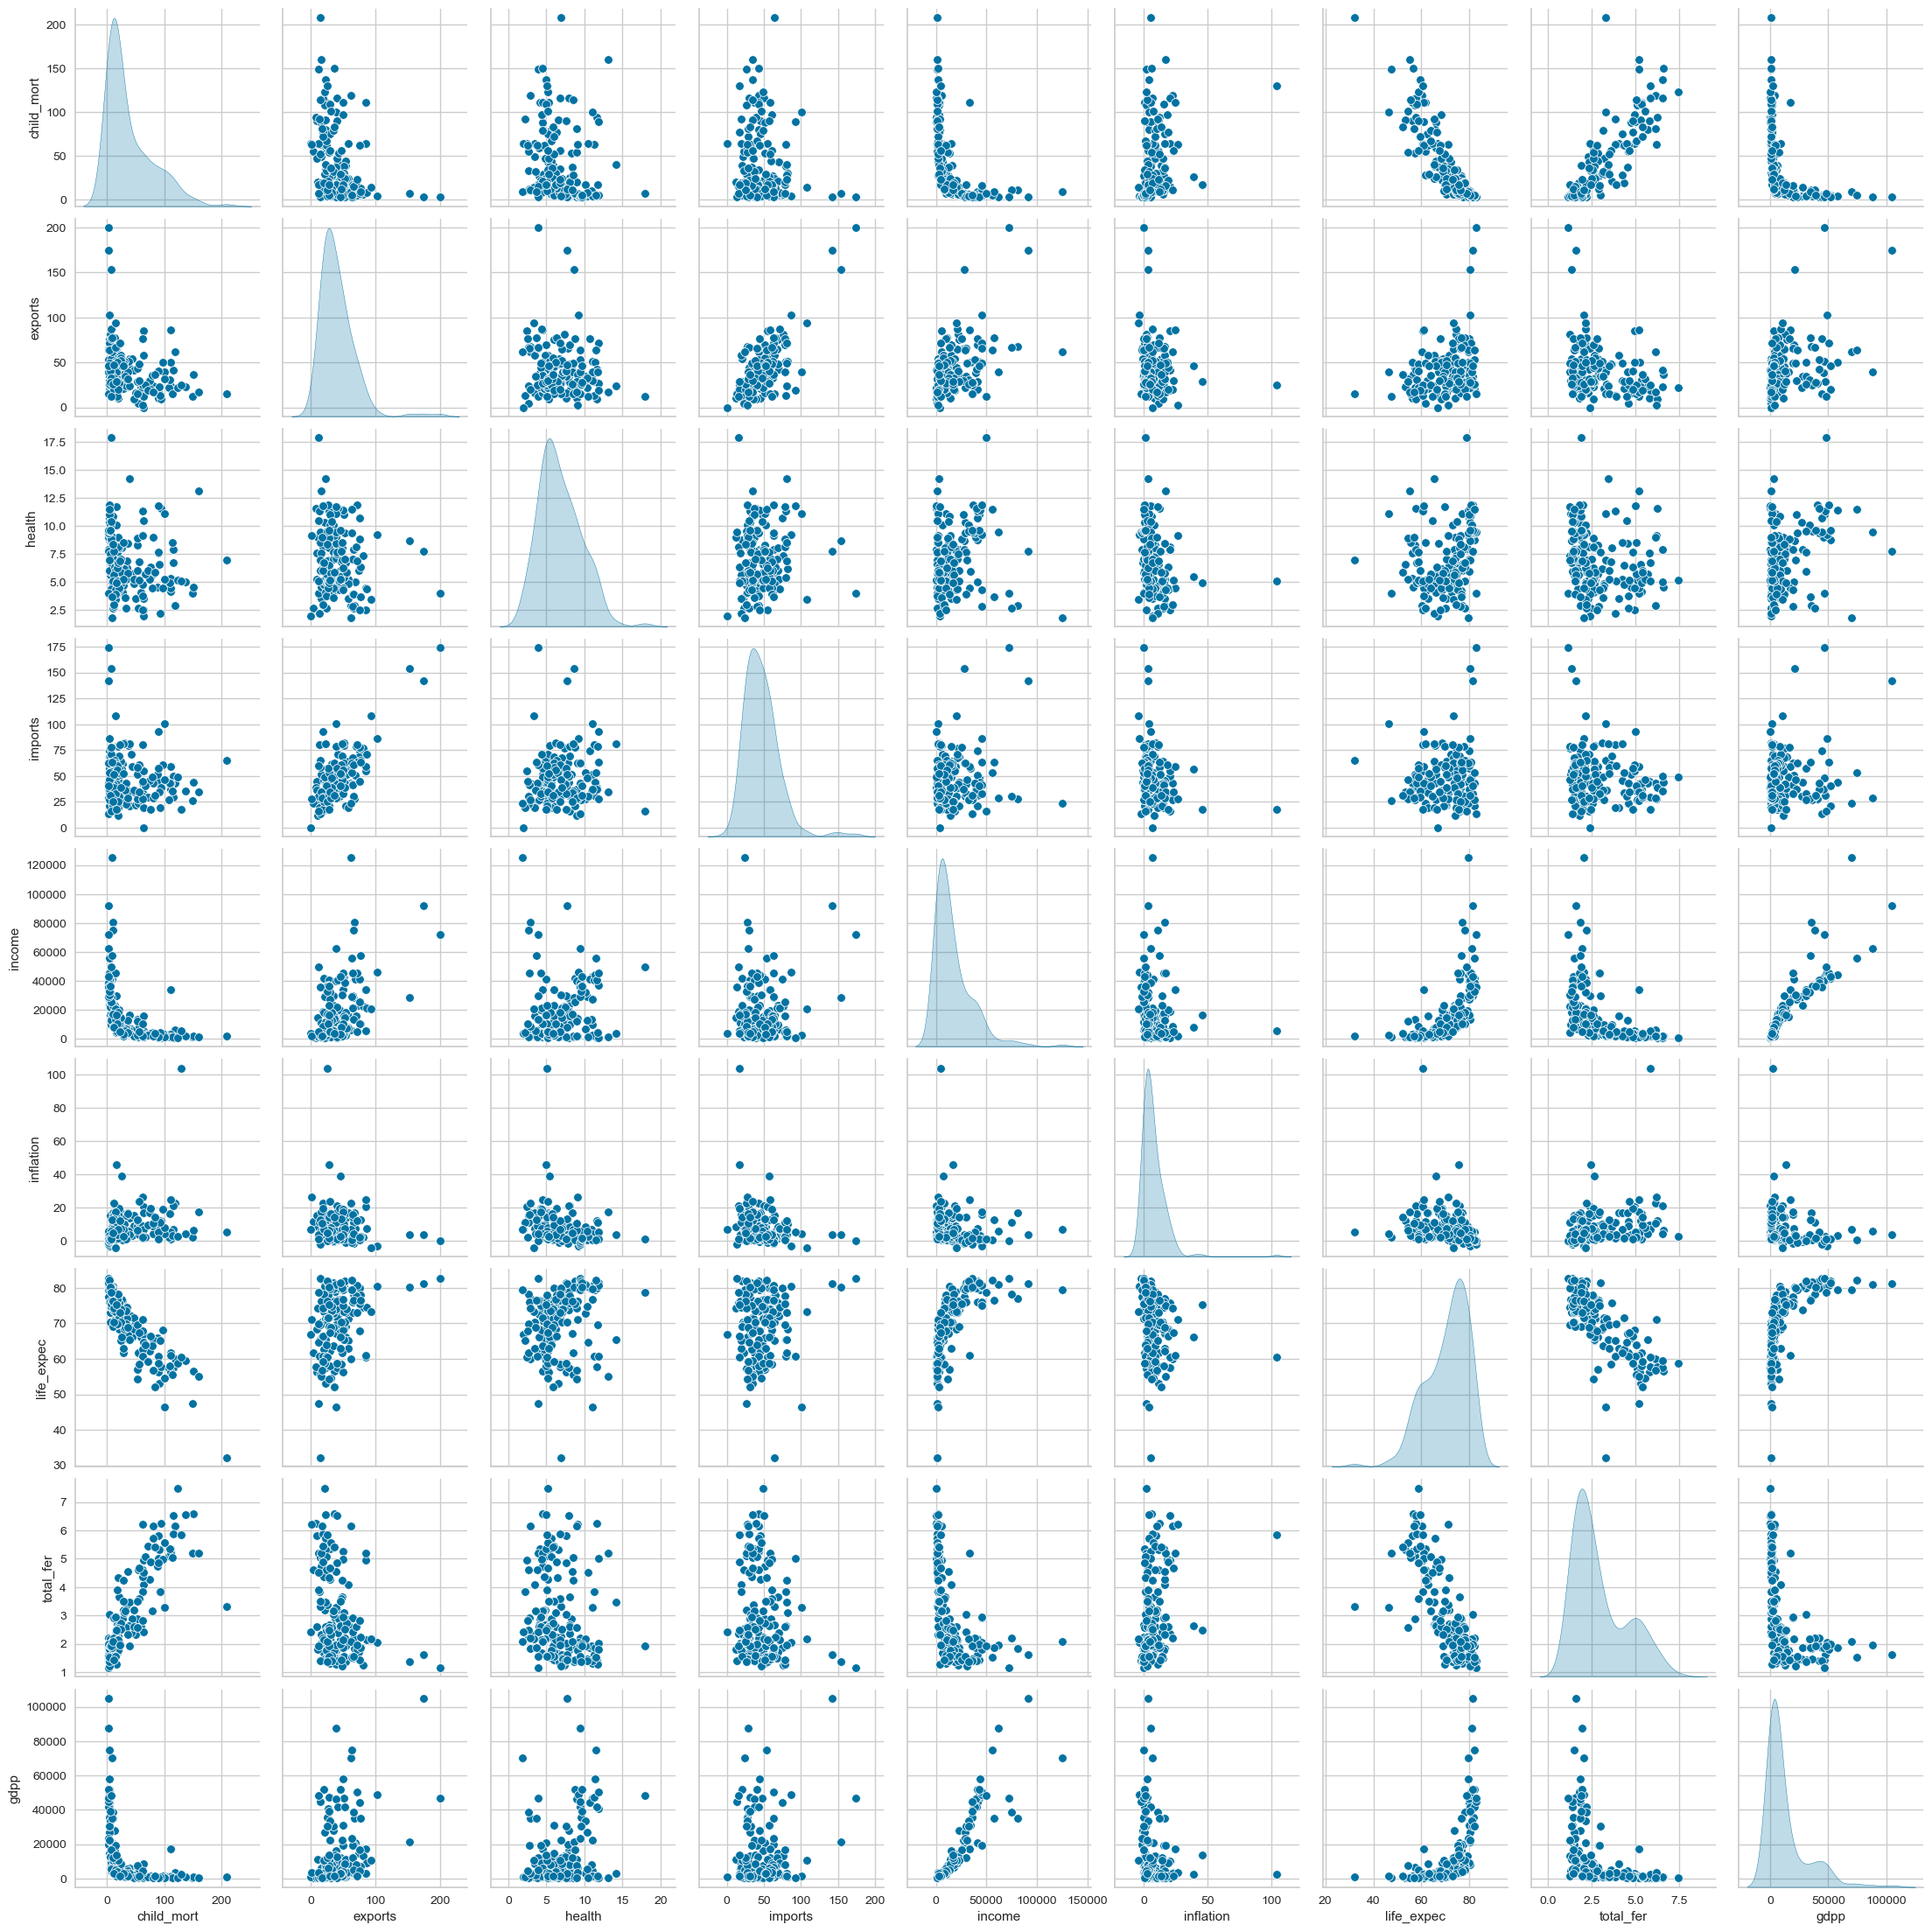

In [12]:
sns.pairplot(data,diag_kind='kde')
plt.show()

In [13]:
# Clean the data

# Check for missing values 
data.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [14]:
# Check for duplicated rows
data.duplicated().sum()

0

**There are no missing values and duplicated rows in the data**

In [15]:
# Treat the outliers (Capping using IQR method)

for i in data.columns:
    q3,q1 = np.percentile(data[i],[75,25])
    iqr = q3-q1
    ul,ll = q3+1.5*iqr, q1-1.5*iqr
    data[i] = data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

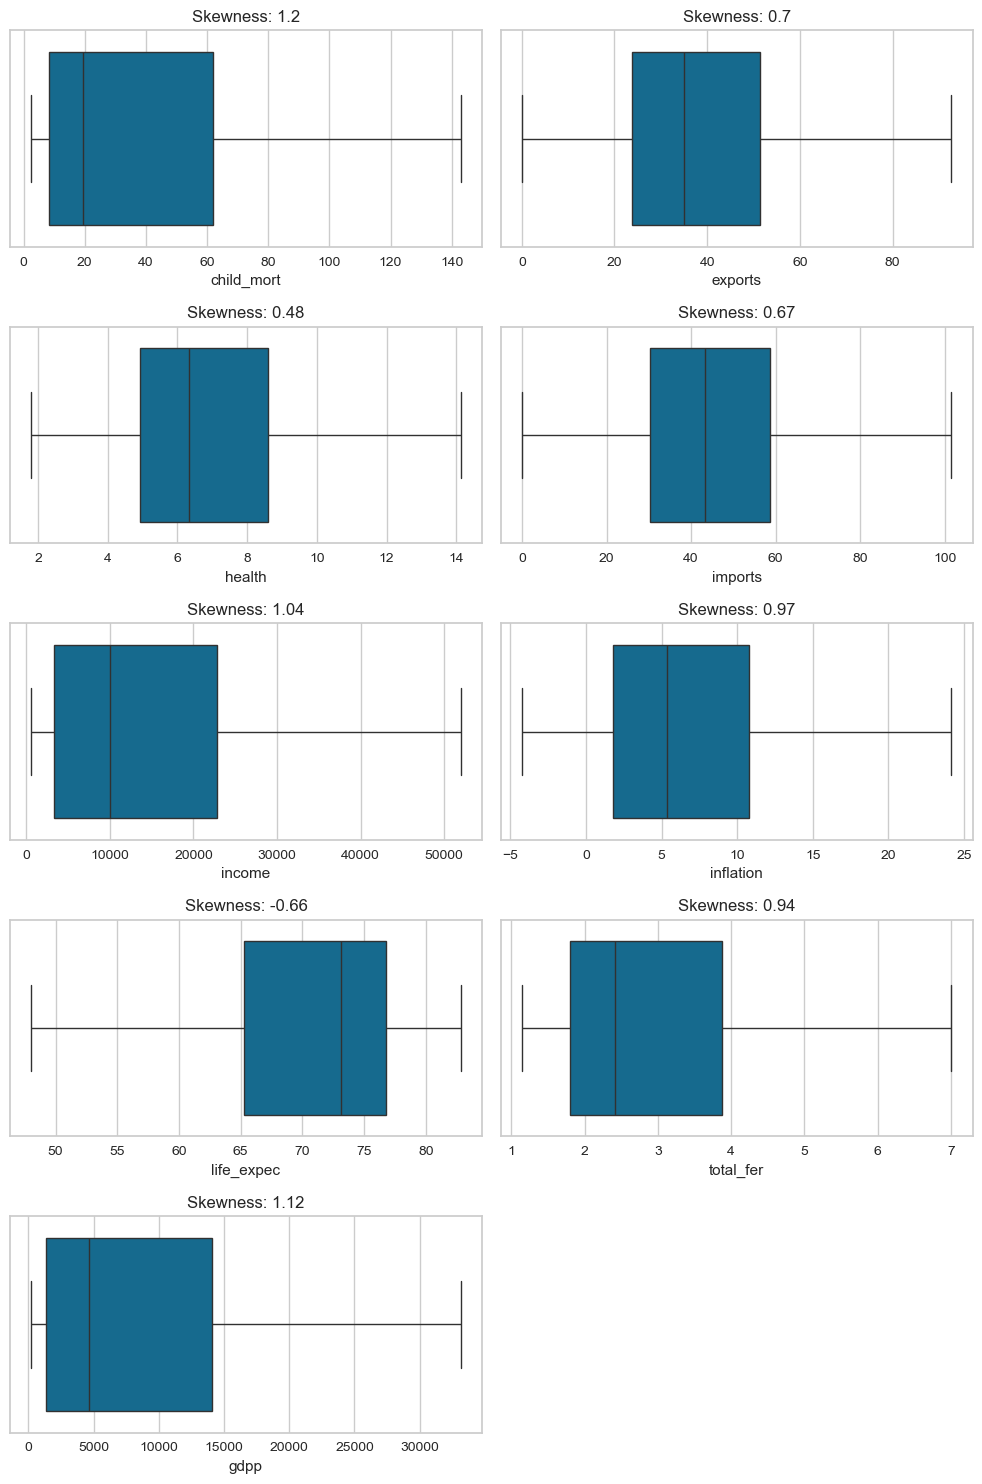

In [16]:
t=1
plt.figure(figsize=(10,15))
for i in data.columns:
    plt.subplot(5,2,t)
    sns.boxplot(data=data,x=i)
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

We will use scaled data for clustering

In [17]:
sc = StandardScaler()

In [18]:
data_s = sc.fit_transform(data)
data_s = pd.DataFrame(data_s,columns=data.columns,index=data.index)
data_s.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.369802,-1.391107,0.296013,-0.047444,-0.943936,0.355270,-1.702225,1.915276,-0.846341
Albania,-0.550464,-0.543547,-0.091190,0.135021,-0.395181,-0.385208,0.663321,-0.862779,-0.540827
Algeria,-0.271295,-0.053846,-0.985893,-0.713196,-0.199291,1.351551,0.686859,-0.036691,-0.508868
Angola,2.121210,1.071524,-1.482114,-0.146074,-0.660984,2.293979,-1.243238,2.141784,-0.589198
Antigua and Barbuda,-0.714835,0.280469,-0.286671,0.642965,0.209637,-0.841463,0.722166,-0.543003,0.159686


## PCA (Principal Component Analysis)

**For better clusters and better visualization**

In [19]:
pca = PCA(n_components=9)

In [20]:
pca.fit(data_s)

PCA(n_components=9)

In [21]:
# lets use % of explaines varince to decide the no of PC's (95% variance)
pca.explained_variance_ratio_.cumsum()

array([0.48892383, 0.65345231, 0.79102018, 0.88606572, 0.95106892,
       0.97118734, 0.98774592, 0.99674059, 1.        ])

In [22]:
pca_final = PCA(n_components=5)
pca_data = pca_final.fit_transform(data_s)

In [23]:
pca_data = pd.DataFrame(pca_data,columns=['PC1','PC2','PC3','PC4','PC5'],
                       index=data_s.index)

In [24]:
pca_data

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.177917,-0.251292,-1.011474,0.778804,-0.014102
Albania,0.434979,-0.218700,-0.292591,-1.391241,0.156711
Algeria,-0.416784,-0.613870,1.637859,-0.615021,0.536604
Angola,-3.306409,1.066649,2.151219,1.698677,0.160551
Antigua and Barbuda,1.253246,0.547778,-0.136955,-0.716890,-0.394628
...,...,...,...,...,...
Vanuatu,-0.882087,0.945856,-0.227550,-0.680105,-0.551247
Venezuela,-0.240053,-1.742315,2.238331,-0.080500,1.318475
Vietnam,0.305579,2.152785,0.455745,-0.746171,1.383759


## Clustering

### k-Means Clustering

In [25]:
# lets identify the value of k

# Elbow plot
kelbow = KElbowVisualizer(KMeans(),k=10)

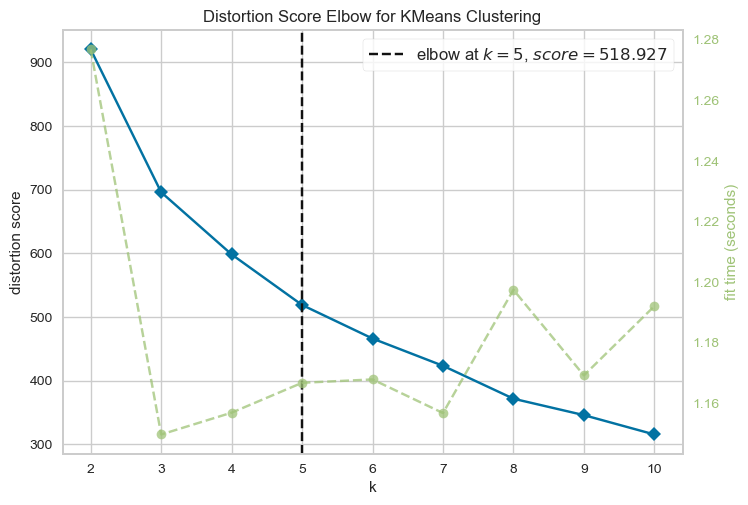

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
kelbow.fit(pca_data)
kelbow.show()

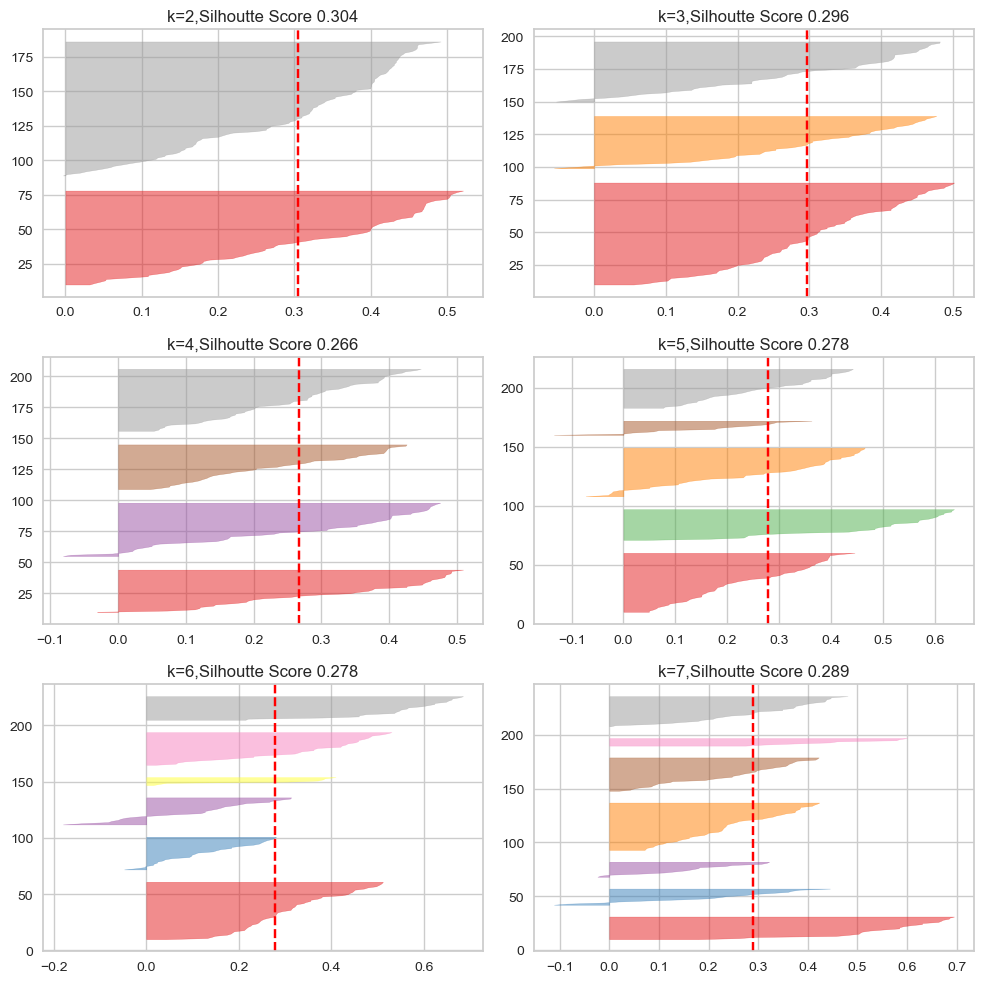

In [27]:
# Silhoutte Visualizer
t=1
plt.figure(figsize=(10,10))
for i in range(2,8):
    plt.subplot(3,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(pca_data)
    plt.title(f'k={i},Silhoutte Score {round(sil_viz.silhouette_score_,3)}')
    t+=1
plt.tight_layout()    
plt.show()

**We can go with k=3**

Reason:
* Although there is no outlier in k=2 but some significant clusters can be created with k=3
* With k=3 we will make one more cluster with approximately same silhoutte score ~0.30

In [28]:
kmean = KMeans(n_clusters=3,random_state=1)
kmean_label = kmean.fit_predict(pca_data)

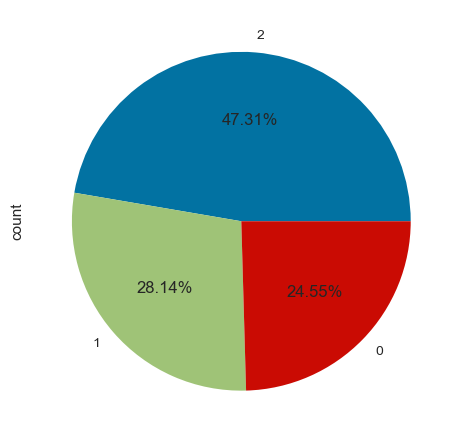

In [29]:
pd.Series(kmean_label).value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

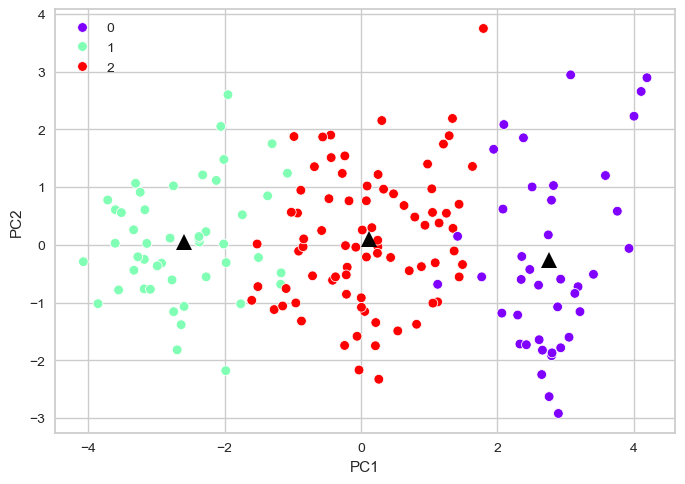

In [30]:
# Visualize the clusters
centroid  = kmean.cluster_centers_
sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=kmean_label,palette='rainbow')
for i in range(3):
    plt.plot(centroid[i][0],centroid[i][1],marker='^',color='black',ms=12)
plt.show()

### Aggloromative Clustering

In [31]:
# lets make dist_mat and link_mat

dist_mat = euclidean_distances(pca_data)
link_mat = linkage(pca_data,method='ward')

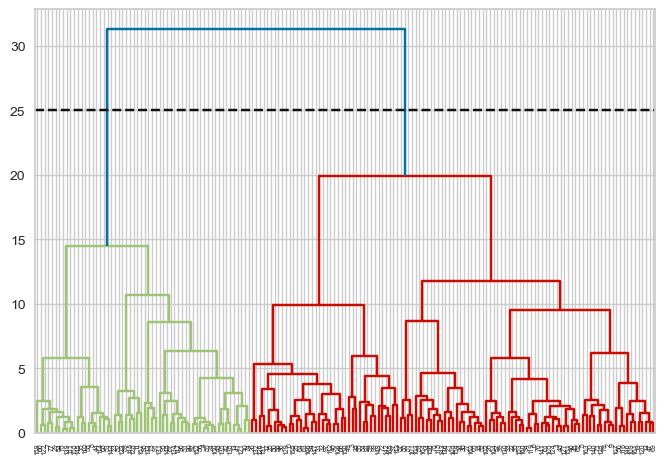

In [32]:
dendrogram(link_mat)
plt.axhline(y=25,ls='--',color='k')
plt.show()

**We can go with wards linkgae method with k=2**

In [33]:
agglo = AgglomerativeClustering(n_clusters=2)

In [34]:
agglo_labels = agglo.fit_predict(pca_data)
print('Silhoutte Score: ',round(silhouette_score(pca_data,agglo_labels),3))

Silhoutte Score:  0.303


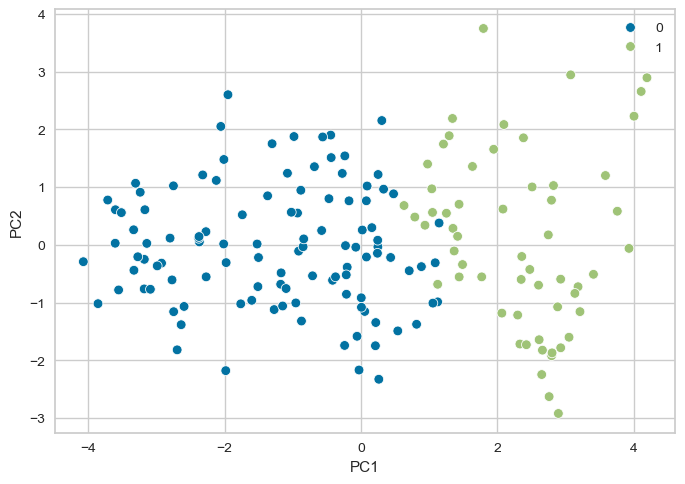

In [35]:
sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=agglo_labels)
plt.show()

## Final Model & Business Interpretation

**Both the algorithms gives approx same Sillhote scores ~0.30. K-Means cluster gives k=3 and Aggloromative gives k=2. We need to decide which clustering model we should go with. Lets go with K-Means as aggloromative is better for hierarchical data, while data has no such hierarchy.**

In [36]:
data['label'] = kmean_label

**Business Interpretation**

In [37]:
data.groupby(by='label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
label,,,,,,,,,
0,5.651220,52.719512,8.331951,47.598171,38988.780488,3.235171,79.514634,1.799756,28969.512195
1,91.182979,28.225936,6.253830,41.233317,3738.574468,10.215426,59.777660,4.987819,1808.297872
2,22.510127,39.438671,6.314177,47.714873,11198.101266,7.178468,72.546835,2.324177,5771.189873


**Inference**

* 0- Has lowest Child_mort than 2 and 1 has highest child_mort.
* % of GDP in exports is highest for 0 and lowest for 1, while 2 has average exports.
* Health index for 0 is clearly better than 1 and 2 both.
* -----
* -----

In [38]:
data['label'] = data['label'].map({0:'Developed',1:'Under_Developed',2:'Developing'})

In [39]:
# lets visualize these Classes

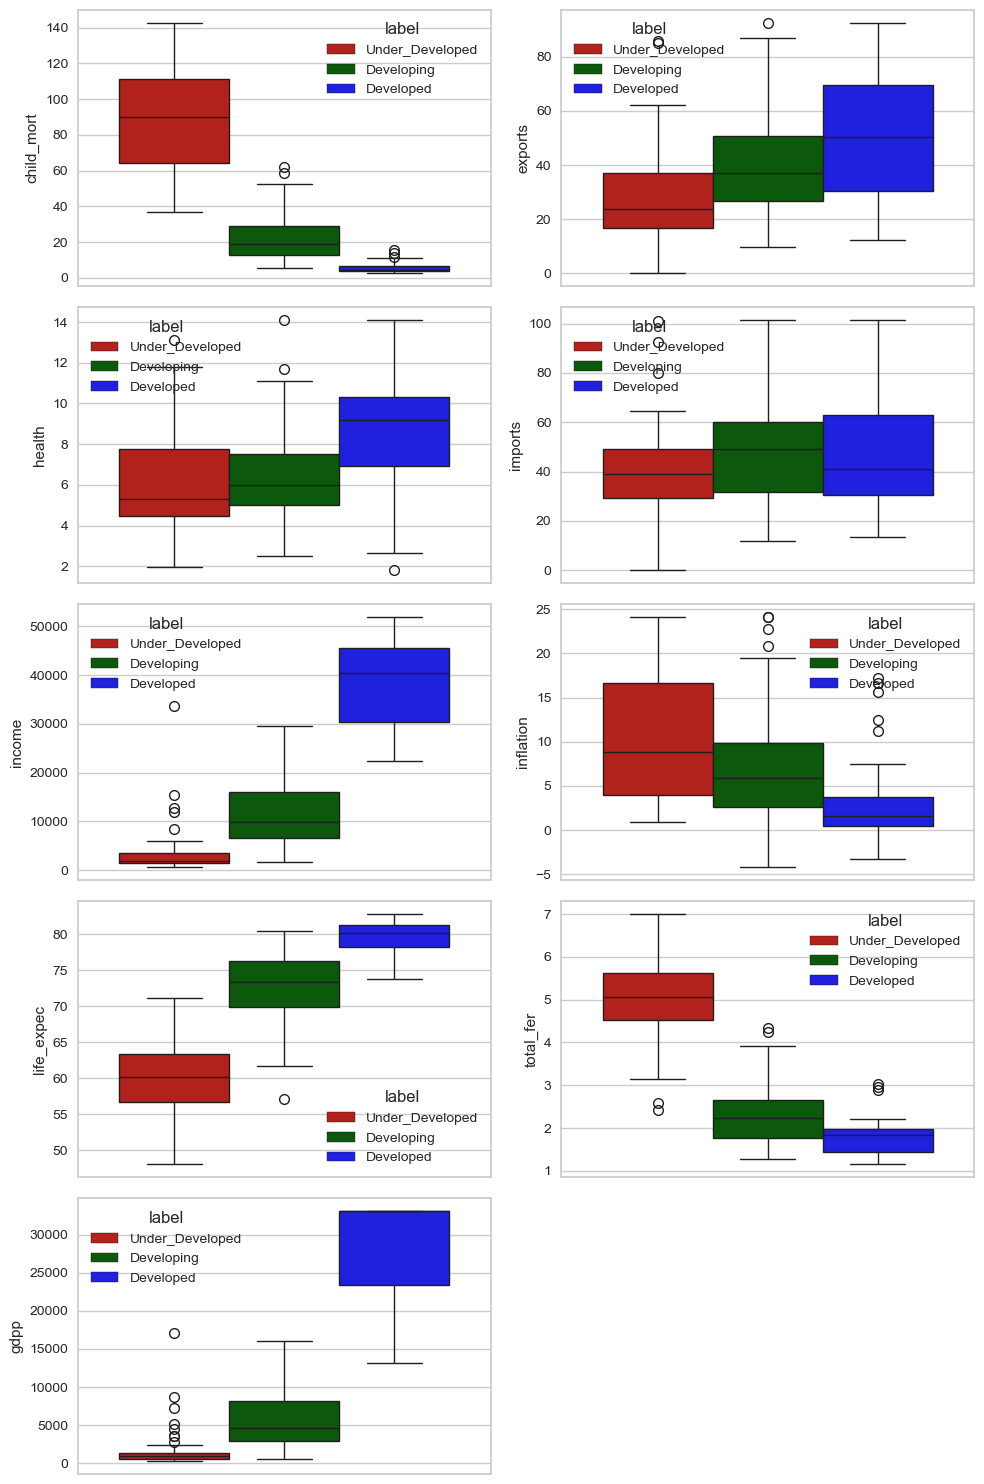

In [40]:
t=1
plt.figure(figsize=(10,15))
for i in data.columns:
    if i!='label':
        plt.subplot(5,2,t)
        sns.boxplot(data,y=i,hue='label',palette=['r','darkgreen','blue'])
        t+=1
plt.tight_layout()
plt.show() 

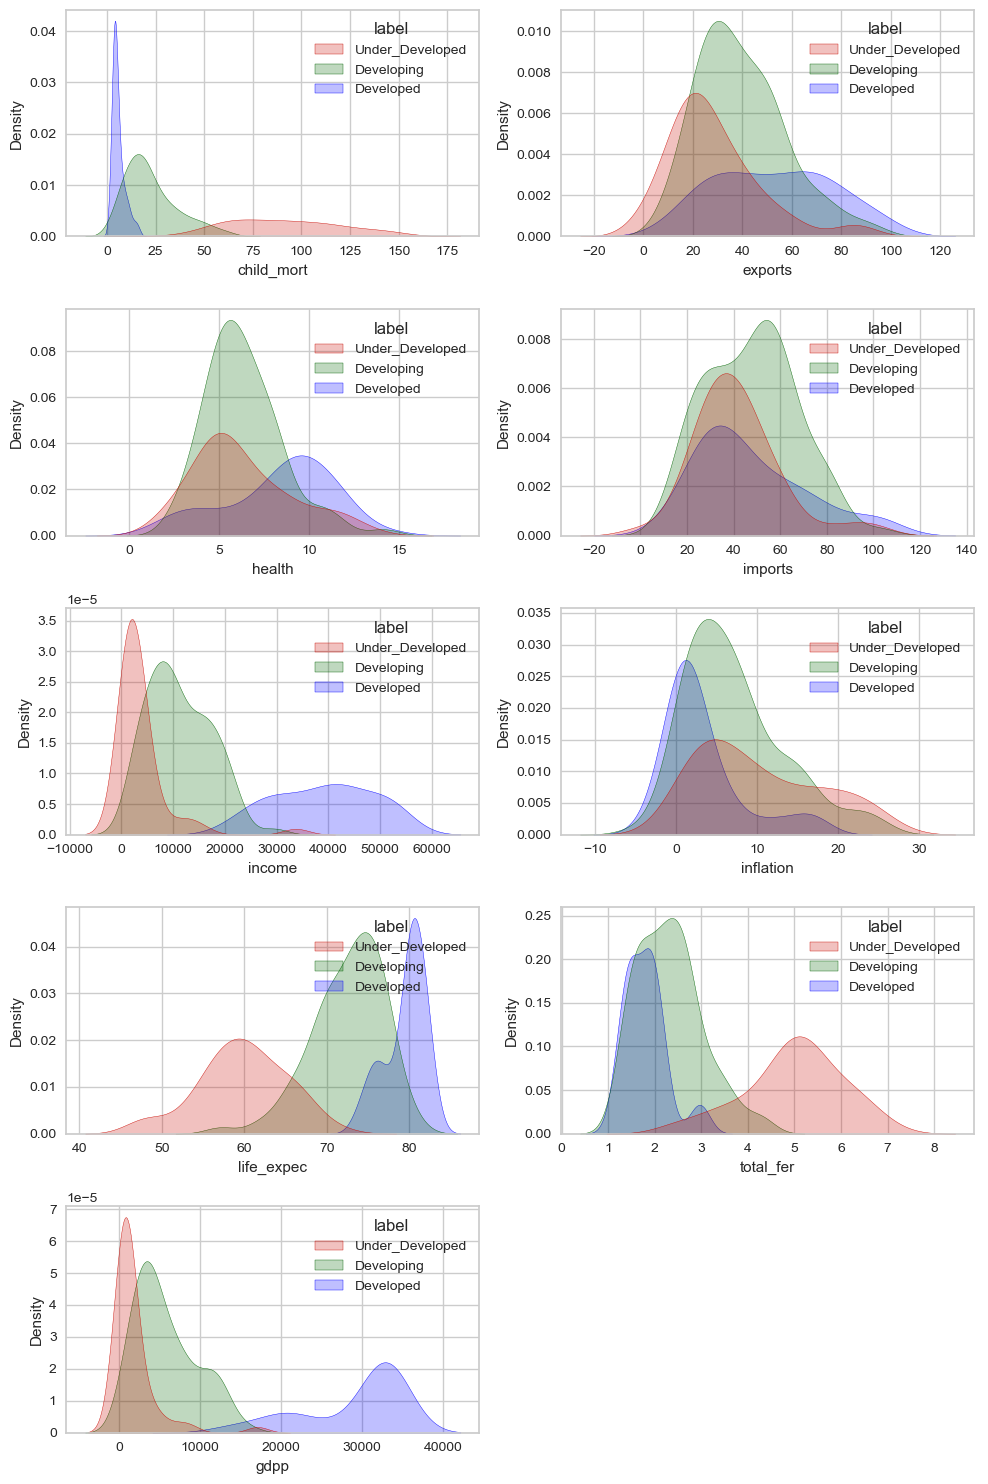

In [41]:
t=1
plt.figure(figsize=(10,15))
for i in data.columns:
    if i!='label':
        plt.subplot(5,2,t)
        sns.kdeplot(data=data,x=i,hue='label',fill=True,palette=['r','darkgreen','blue'])
        t+=1
plt.tight_layout()
plt.show()

In [42]:
# List of countries in all the classes
data[data['label']=='Under_Developed'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea', 'Eritrea', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya',
       'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'Nigeria',
       'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa',
       'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen',
       'Zambia'],
      dtype='object', name='country')

In [43]:
data[data['label']=='Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Serbia', 'Seychelles', 'Solomon Islands',
       'Sri Lanka', 'St. Vincent and the Grenadines', 'Suriname', 'Tajikistan',
       'Thailand', 'Tonga', 'Tunisia', 'Tu

In [44]:
data[data['label']=='Developed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Malta',
       'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

### World Map

In [45]:
import plotly.express as px

In [52]:
# create a data of country and label
world_data = pd.DataFrame({'Label':data['label']})
world_data.reset_index(inplace=True)
world_data.head()

,country,Label
0,Afghanistan,Under_Developed
1,Albania,Developing
2,Algeria,Developing
3,Angola,Under_Developed
4,Antigua and Barbuda,Developing


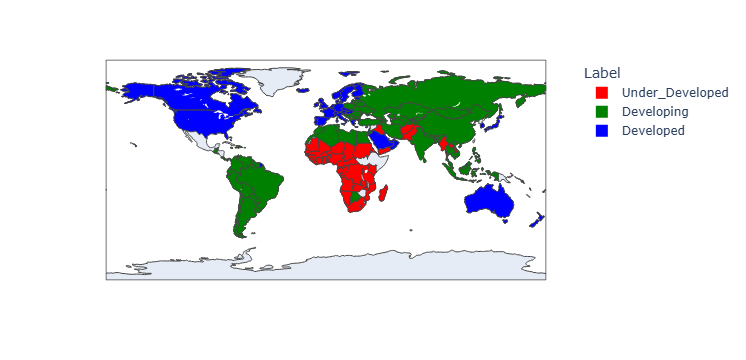

In [67]:
fig = px.choropleth(data_frame=world_data,locationmode='country names',
                   locations='country',color=world_data['Label'],
                    color_discrete_map={'Developed':'blue',
                                       'Under_Developed':'red',
                                       'Developing':'green'})
fig.show()